In [9]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import markov_sim as markov
import json
import os
from datetime import datetime
from re import sub
from dateutil import  parser
import scipy

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'
data_list = []


In [10]:

for line in open('1.145414064.json', 'r'):
    data_list.append(json.loads(line))

runner_id = 2249834
runner_id_2 = 2251410
market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
market_timestamp = datetime.timestamp(market_datetime) * 1000


def get_list(runner_id):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)
    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df = df.resample('250ms').last()
    print(df)
    return df

def calc_pup():
    pass


def get_current_spread():
    pass


def calc_future_spread():
    pass


def calc_score():
    pass


def get_markov_odds():
    pass



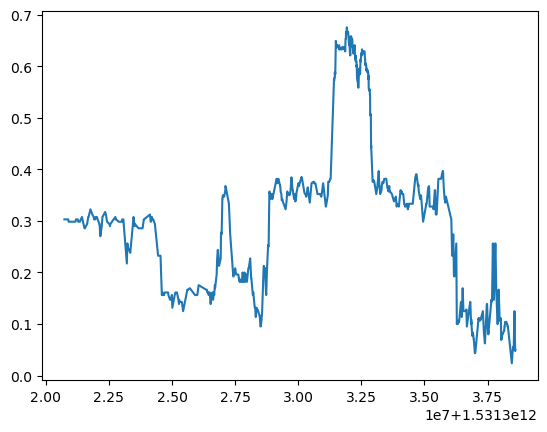

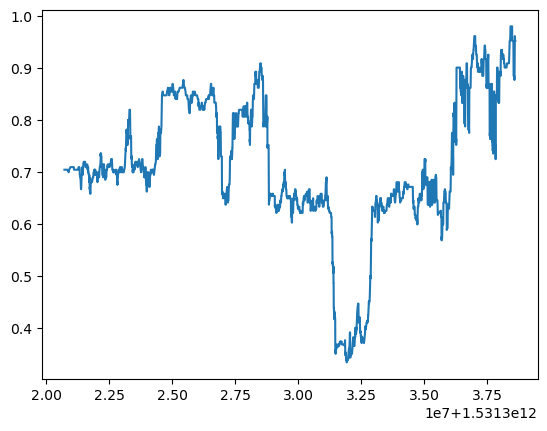

In [11]:
runner_list_1 = get_list(runner_id)
runner_list_2 = get_list(runner_id_2)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)

plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.show()
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])
plt.show()

In [12]:
df = odds_avg(runner_odds_1, runner_odds_2)

                         runner 1  1 - runner 2       avg
2018-07-11 14:52:07.000   0.30303      0.295775  0.299402
2018-07-11 14:52:07.250   0.30303      0.295775  0.299402
2018-07-11 14:52:07.500   0.30303      0.295775  0.299402
2018-07-11 14:52:07.750   0.30303      0.295775  0.299402
2018-07-11 14:52:08.000   0.30303      0.295775  0.299402
...                           ...           ...       ...
2018-07-11 19:50:14.500   0.05000      0.047619  0.048810
2018-07-11 19:50:14.750   0.05000      0.047619  0.048810
2018-07-11 19:50:15.000   0.05000      0.047619  0.048810
2018-07-11 19:50:15.250   0.05000      0.047619  0.048810
2018-07-11 19:50:15.500   0.05000      0.047619  0.048810

[71555 rows x 3 columns]


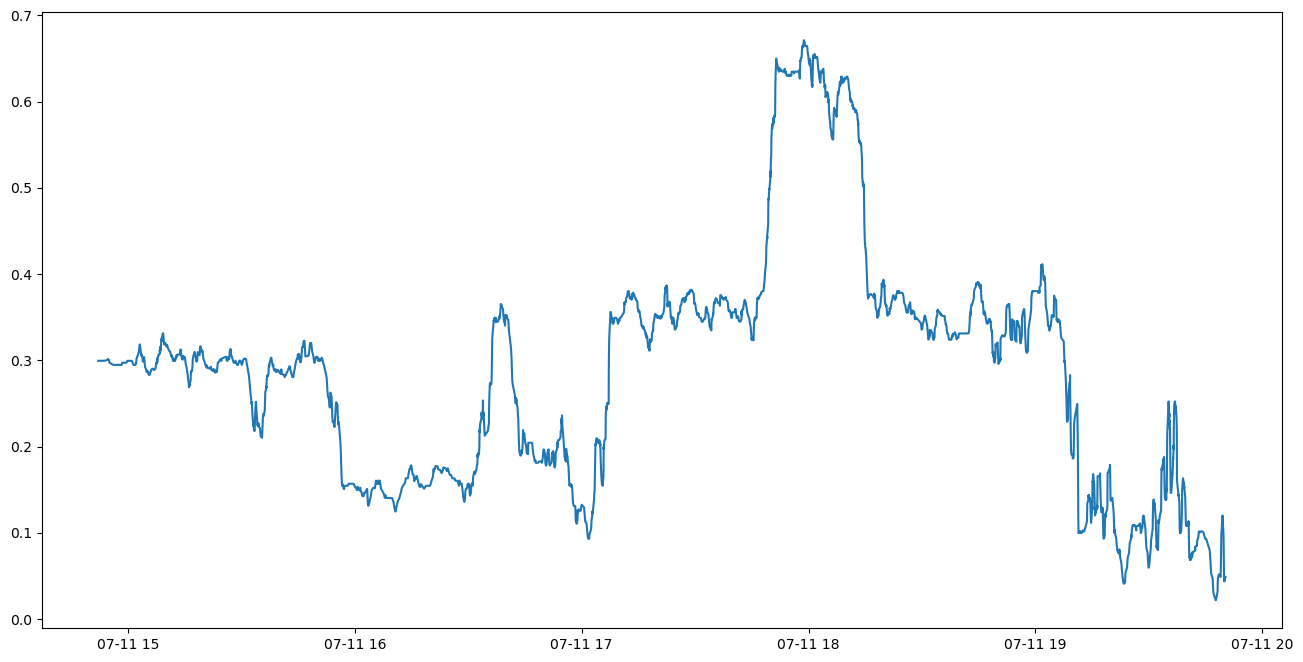

In [13]:
plt.figure(figsize=(16,8))
plt.plot(df['avg'])

In [9]:
print(df['avg'])

2018-07-11 10:02:39.600    0.297141
2018-07-11 10:02:39.700    0.297142
2018-07-11 10:02:39.800    0.297142
2018-07-11 10:02:39.900    0.297143
2018-07-11 10:02:40.000    0.297144
                             ...   
2018-07-11 19:50:15.300    0.048810
2018-07-11 19:50:15.400    0.048810
2018-07-11 19:50:15.500    0.048810
2018-07-11 19:50:15.600    0.048810
2018-07-11 19:50:15.700    0.048810
Name: avg, Length: 352562, dtype: float64
